In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np


In [16]:
#Carregamos os dados
df = pd.read_json('new_rotten_tomatoes_dataset.json')

In [17]:
df

,title,year,emsId,vanity,type,critics_score,audience_score,genres,directors,cast,full_consensus,full_title,full_image,critic_reviews
0,Prisoner of War,2025,58c6801a-d7d0-49d4-a200-07e9f8e6004f,prisoner_of_war,movie,67.0,NaN,"[Action, Mystery & Thriller, War]",[],"[{'role': 'Actor', 'emsId': 'c8ab0109-b9e3-318...",None,Prisoner of War,https://resizing.flixster.com/BBVn1zu0ytWcN2rI...,"[{'critic_name': 'Keith Garlington', 'review_t..."
1,War of the Worlds,2025,2828f421-1ed7-430d-94c3-e19235ba0d43,war_of_the_worlds_2025,movie,4.0,20.0,"[Sci-Fi, Adventure, Drama, Mystery & Thriller]",[],"[{'role': 'Actor', 'emsId': 'c745b7d3-1c29-394...",Critics Consensus\n \nStranding Ice Cub...,War of the Worlds,https://resizing.flixster.com/YwVygNhpYTtDgJ5N...,"[{'critic_name': 'Clement Tyler Obropta', 'rev..."
2,Female War: A Nasty Deal,2015,05b14108-fbb6-3e04-86f7-cdc2d40bef0b,female_war_a_nasty_deal,movie,NaN,83.0,[Drama],[],"[{'role': 'Actor', 'emsId': 'a693f4c5-2ca7-33a...",None,Female War: A Nasty Deal,none,[]
3,This Means War,2012,de81052c-61c1-36ba-9366-5c396e4a2b67,this_means_war,movie,24.0,56.0,"[Action, Comedy]",[],"[{'role': 'Actor', 'emsId': 'e9ed7eb8-7773-3b6...",Critics Consensus\n \nA career lowlight...,This Means War,https://resizing.flixster.com/gdTg56URfE7W9P3F...,"[{'critic_name': 'Brian Eggert', 'review_text'..."
4,Love+War,2025,e62b7347-0c01-44d9-a36a-5310b461243b,love_and_war_2025,movie,100.0,NaN,"[Documentary, War, Biography, History]",[],"[{'role': 'Self', 'emsId': '165fbc83-6be1-3167...",None,Love+War,https://resizing.flixster.com/RlYWkCPgGQfWIsZ-...,"[{'critic_name': 'Jeremy Aspinall', 'review_te..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3588,Shepard and Dark,2012,f21de9dd-f1b6-3f2b-b086-0062c2ee3194,shepard_and_dark,movie,86.0,68.0,[Drama],[],[],None,Shepard and Dark,https://resizing.flixster.com/GwQqud9nQYidcWoM...,"[{'critic_name': 'Marc Savlov', 'review_text':..."
3589,Hitcher in the Dark,1989,13700dbc-a9c1-3c75-8fa6-9ccee4b8a79e,hitcher_in_the_dark,movie,NaN,10.0,[Mystery & Thriller],[],"[{'role': 'Actor', 'emsId': '98c589b1-8579-381...",None,Hitcher in the Dark,https://resizing.flixster.com/VGtOK4q4N08wAowD...,"[{'critic_name': 'Brian Orndorf', 'review_text..."
3590,Shocking Dark,1989,61840258-9a21-3b71-8f17-9386236c9889,terminator-ii-shocking-dark,movie,NaN,18.0,"[Action, Sci-Fi]",[],"[{'role': 'Actor', 'emsId': '5c84b708-0ff2-3a4...",None,Shocking Dark,https://resizing.flixster.com/8Xwpn5j3Ui77NQ9u...,"[{'critic_name': 'Mike Massie', 'review_text':..."
3591,In the Dark Half,2012,a25471f1-7486-3d49-8e7e-3dc970f63c0e,in_the_dark_half,movie,67.0,26.0,"[Drama, Mystery & Thriller]",[],"[{'role': 'Actor', 'emsId': '819bd1ea-831f-328...",None,In the Dark Half,https://resizing.flixster.com/kqjdHNEaW4agvttv...,"[{'critic_name': 'Patrick Gamble', 'review_tex..."


In [18]:
#Vemos quais são as colunas do dataset
df.columns

Index(['title', 'year', 'emsId', 'vanity', 'type', 'critics_score',
       'audience_score', 'genres', 'directors', 'cast', 'full_consensus',
       'full_title', 'full_image', 'critic_reviews'],
      dtype='object')

In [19]:
#Vamos filtrar apenas o que importa pra NLP, mantemos "full_consensus" (texto) e "critics_score" (para gerar a classe usando com base as notas)
df = df[['full_consensus', 'critics_score']].copy()

In [20]:
#Removemos as linhas onde o "full_consensus" está vazio pois não tem o que processar
df = df.dropna(subset=['full_consensus'])
df = df[df['full_consensus'].str.strip() != ""]

In [21]:
#Criamos a coluna de classificação seguindo a regra do Rotten Tomatoes: notas >= 60 são "Fresh" (1) e < 60 são "Rotten" (0)
df['opiniao'] = df['critics_score'].apply(lambda x: 1 if x >= 60 else 0)

In [22]:
#Removemos a "critics_score" já que agora temos a classe
df = df.drop(columns=['critics_score'])

Contagem original das classes:
opiniao
1    1261
0     631
Name: count, dtype: int64


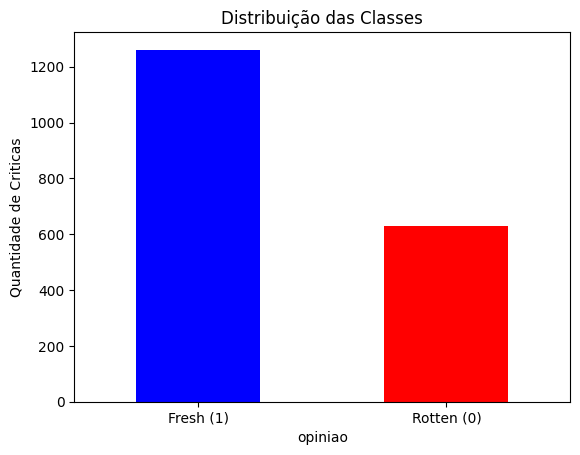

In [23]:
#Vamos verificar a contagem de cada classe
print("Contagem original das classes:")
print(df['opiniao'].value_counts())

df['opiniao'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribuição das Classes')
plt.xticks([0, 1], ['Fresh (1)', 'Rotten (0)'], rotation=0)
plt.ylabel('Quantidade de Criticas')
plt.show()

In [24]:
#Vamos fazer um balanceamento, pois está muito desigual
#Separamos as classes
df_fresh = df[df['opiniao'] == 1]
df_rotten = df[df['opiniao'] == 0]

#Vamos sortear da classe "Fresh" a mesma quantidade que temos no "Rotten"
df_fresh_reduzido = df_fresh.sample(n=len(df_rotten), random_state=42)

#Agora juntamos as duas partes
df = pd.concat([df_fresh_reduzido, df_rotten])

#Vamos embaralhar o dataset agora, para que o modelo não receba todas as positivas e depois as negativas e vice versa
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(df['opiniao'].value_counts())

opiniao
0    631
1    631
Name: count, dtype: int64


In [25]:
#Separamos em treino e teste e garantimos que seja reproduzivel com o random_state
X = df['full_consensus']
y = df['opiniao']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
print(f"Treino: {len(X_train)} reviews | Teste: {len(X_test)} reviews")

Treino: 1009 reviews | Teste: 253 reviews


Preparação e limpeza

In [13]:
pipeline_bow = Pipeline([
    ('vect', CountVectorizer()), #Cria um vetor com as palavras do dataset, e para cada review ele gera uma lista de números dizendo quantas vezes cada palavra apareceu
    ('clf', LogisticRegression(max_iter=1000))#Ele recebe as contagens e aprende os pesos
])

param_grid_bow = {
    'vect__ngram_range': [(1, 1), (1, 2)], #Olha palavras soltas e pares de palavras
    'vect__min_df': [2, 5],                 #Remove as palavras que raramente aparecem(em menos de 5 criticas)
    'vect__max_df': [0.8, 0.9],             #Remove as palavras "stopwords implícitas"(tipo movie que é muito constante mas não indica nada)
    'clf__C': [0.1, 1, 10]                  #Hiperparâmetro do modelo (0.1 =regularização mais forte para tentar evitar que o modelo "decore" o treino/overfitting
                                            #1.0 = padrão do Sklearn, 10 =liberdade para o modelo tentar acertar todos os pontos do treino)
}

grid_bow = GridSearchCV(pipeline_bow, param_grid_bow, cv=5, scoring='f1', n_jobs=-1)
grid_bow.fit(X_train, y_train)

print(f"Melhores parâmetros do Bag of Words: {grid_bow.best_params_}")
print(f"Melhor F1-Score do treino: {grid_bow.best_score_:.4f}")

Melhores parâmetros do Bag of Words: {'clf__C': 10, 'vect__max_df': 0.8, 'vect__min_df': 2, 'vect__ngram_range': (1, 2)}
Melhor F1-Score do treino: 0.7639


Bag of Words

In [14]:
pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()), #Conta quantas vezes a palavra aparece na review e diminui o valor de palavras que aparecem em muitos documentos
    ('clf', LogisticRegression(max_iter=1000))#Ele toma decisões baseadas na importância
])


param_grid_tfidf = {
    'tfidf__ngram_range': [(1, 1), (1, 2)], #Olha palavras soltas e pares de palavras
    'tfidf__min_df': [2, 5],                #Remove as palavras que raramente aparecem(em menos de 5 criticas)
    'tfidf__sublinear_tf': [True, False],   #Escala logaritmica que foi pedido no trabalho
    'clf__C': [0.1, 1, 10]                  #Hiperparâmetro do modelo (0.1 =regularização mais forte para tentar evitar que o modelo "decore" o treino/overfitting
                                            #1.0 = padrão do Sklearn, 10 =liberdade para o modelo tentar acertar todos os pontos do treino)
}

grid_tfidf = GridSearchCV(pipeline_tfidf, param_grid_tfidf, cv=5, scoring='f1', n_jobs=-1)
grid_tfidf.fit(X_train, y_train)

print(f"Melhores parâmetros TF-IDF: {grid_tfidf.best_params_}")
print(f"Melhor F1-Score do treino: {grid_tfidf.best_score_:.4f}")

Melhores parâmetros TF-IDF: {'clf__C': 10, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True}
Melhor F1-Score do treino: 0.7695


TF-IDF


--- Desempenho do melhor modelo ---
              precision    recall  f1-score   support

      Rotten       0.82      0.80      0.81       127
       Fresh       0.80      0.83      0.81       126

    accuracy                           0.81       253
   macro avg       0.81      0.81      0.81       253
weighted avg       0.81      0.81      0.81       253



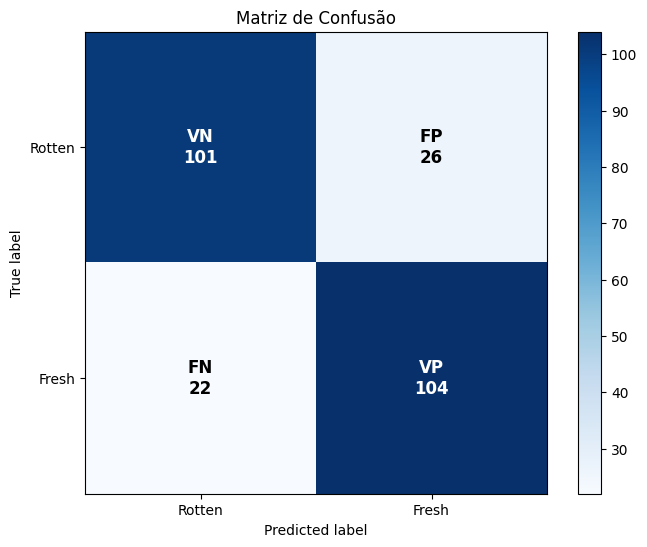

In [27]:
#Aqui vamos avaliar o melhor modelo
best_model = grid_tfidf.best_estimator_
y_pred = best_model.predict(X_test)

print("\n--- Desempenho do melhor modelo ---")
print(classification_report(y_test, y_pred, target_names=['Rotten', 'Fresh']))

#Vamos criar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
vn, fp, fn, vp = cm.ravel()

labels = np.array([
    [f"VN\n{vn}", f"FP\n{fp}"],
    [f"FN\n{fn}", f"VP\n{vp}"]
])

#Plotamos
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Rotten', 'Fresh'])

disp.plot(cmap='Blues', ax=ax, include_values=False)

for i in range(2):
    for j in range(2):
        ax.text(j, i, labels[i, j], ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black", fontsize=12, fontweight='bold')

plt.title("Matriz de Confusão")
plt.show()

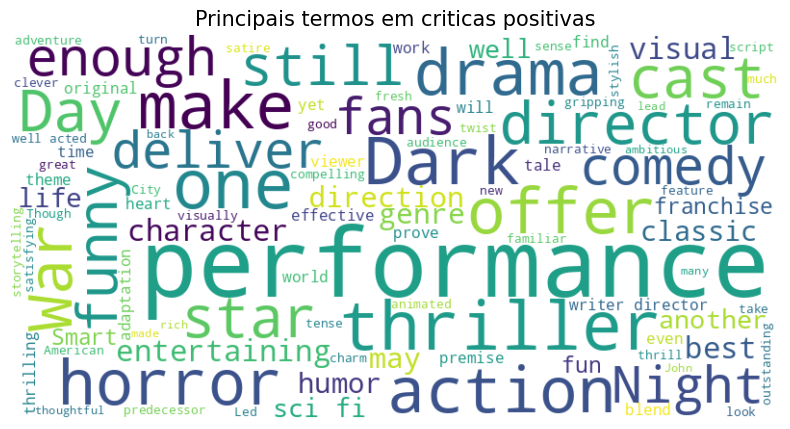

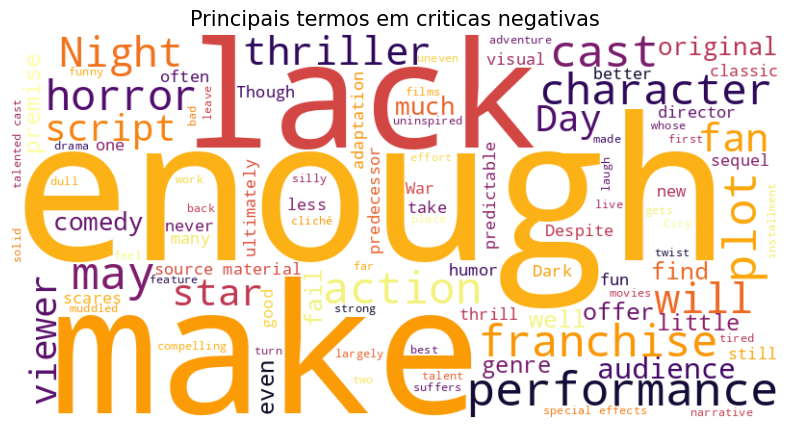

In [28]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#Aqui vamos pegar algumas palavras que se repetem em todas as reviews que não indicam nada
outras_stopwords = set(['Critics', 'Consensus', 'Reviews', 'Read', 'Full', 'Movie', 'Film', 'Story'])
meus_stopwords = STOPWORDS.union(outras_stopwords)

def gerar_nuvem(df_filtrado, titulo, cor):
    #Junta todo o texto
    texto = " ".join(review for review in df_filtrado.full_consensus)

    #Geramos a nuvem ignorando as palavras genericas
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=meus_stopwords,
        max_words=100,
        colormap=cor
    ).generate(texto)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(titulo, fontsize=15)
    plt.show()

#Printamos as nuvens
gerar_nuvem(df[df['opiniao'] == 1], 'Principais termos em criticas positivas', 'viridis')
gerar_nuvem(df[df['opiniao'] == 0], 'Principais termos em criticas negativas', 'inferno')